#### Load required libraries

In [2]:
import numpy as np
import logging
import pickle
# required libraries for Reconstructor matrix computation or MPC
from scipy import sparse
import matplotlib.pyplot as plt

import os.path
from os import path

from pathlib import Path
import dos

sim_folder = 'dos/SHWFS'

#### Compute reconstructor from interacion matrix

In [3]:
# * * * Flag to control if reconstructor matrix is updated * * *
updateReconst = True

if (not path.exists(sim_folder+'/ReconstructorM.pickle')) or (updateReconst):
    # Open reconstructor pickle data file
    if(sim_folder == 'dos/SHWFS'):
        RecAnalysis_folder = '/Users/rromano/Workspace/ActiveOptics/Reconstructor'
        file = open(RecAnalysis_folder+'/AcO_SHWFS_Rec.pickle', 'rb')

    RecDt = pickle.load(file)

    if(sparse.issparse(RecDt['RecM'])):
        RecM = RecDt['RecM'].toarray()
    else:
        RecM = RecDt['RecM']
        
    Msimceo = np.zeros_like(RecM)    
    n_bm = (RecM.shape[0] - 84)//7

    for k in range (7):
        row_sel = np.hstack([np.arange(6)+6*k,
                             np.arange(42,48)+6*k,
                             np.arange(84,84+n_bm)+n_bm*k])
        Msimceo[len(row_sel)*k:len(row_sel)*(k+1),:] = RecM[row_sel,:]
    
    # Generate SIMCEO reconstructor pickle file
    dos.tools.linear_estimator_2_dos(Msimceo,sim_folder+'/ReconstructorM', B_or_D='D')
    print('SH-WFS reconstructor matrix pickle file is updated!')

SH-WFS reconstructor matrix pickle file is updated!


#### Set initial M1/M2 states and generate respective yaml files

In [23]:
# Python code to set simulation states...
from ruamel import yaml
from ruamel.yaml import YAML

# * * * Flag to control if simulation initial state is updated * * *
updateState0 = True

asec2rad = 4.84814e-6
n_bm = 46
k_states = 1
x0 = np.zeros(42+42+7*n_bm)

if (not path.exists(sim_folder+'/M1.yaml')) or (updateState0):
    # M1 random initial values
    x0_M1_Txy = k_states*75.0e-6*np.random.randn(7,2)
    x0_M1_Tz = k_states*np.hstack([160.0e-6*np.random.randn(6),0]).reshape((7, 1))
    x0_M1_Rxy = k_states*0.38*asec2rad*np.random.randn(7,2)
    x0_M1_Rz = k_states*40*asec2rad*np.random.randn(7,1)
    x0_BM = k_states*4e-6*np.random.randn(7, n_bm)

    
    M1dict = {
        'mirror' : 'M1',
        'mirror_args': {'mirror_modes': 'bending modes', 
                        'N_MODE': n_bm},
        'state': {'Txyz': np.hstack([x0_M1_Txy, x0_M1_Tz]).tolist(),
                  'Rxyz': np.hstack([x0_M1_Rxy, x0_M1_Rz]).tolist(),
                  'modes': x0_BM.tolist() }
    }
    # Dump M1 inital state
    y = YAML()
    y.default_flow_style = None
    with open(Path(sim_folder)/'M1.yaml','w') as f:
        y.dump(M1dict, f)

if (not path.exists(sim_folder+'/M2.yaml')) or (updateState0):        
    # M2 random initial values
    x0_M2_Txy = k_states*75.0e-6*np.random.randn(7,2)
    x0_M2_Tz = k_states*170.0e-6*np.random.randn(7,1)
    x0_M2_Rxy = k_states*3.0*asec2rad*np.random.randn(7,2)
    x0_M2_Rz = k_states*330*asec2rad*np.random.randn(7,1)

    M2dict = {
        'mirror' : 'M2',
        'mirror_args': {},
        'state': {'Txyz': np.hstack([x0_M2_Txy, x0_M2_Tz]).tolist(),
                  'Rxyz': np.hstack([x0_M2_Rxy, x0_M2_Rz]).tolist()}
    }
    # Dump M2 inital state
    with open(Path(sim_folder)/'M2.yaml','w') as f:
        y.dump(M2dict, f)


#### Instantiate DOS

In [17]:
sim = dos.DOS(sim_folder,verbose=logging.INFO,show_timing=2)

INFO:DOS:Reading config from dos/SHWFS/dos.yaml
INFO:DOS:New driver: M1
INFO:M1:New input: Txyz
INFO:M1:New input: Rxyz
INFO:M1:New input: modes
INFO:M1:No inputs!
INFO:DOS:New driver: M2
INFO:M2:New input: Txyz
INFO:M2:New input: Rxyz
INFO:M2:No inputs!
INFO:DOS:New driver: wfs48
INFO:wfs48:No inputs!
INFO:wfs48:New output: data
INFO:wfs48:New output: M12_RBM
INFO:wfs48:Output logged in!
INFO:DOS:New driver: ReconstructorM
INFO:ReconstructorM:New input: SH-WFS
INFO:ReconstructorM:New output: x_hat
INFO:ReconstructorM:Output logged in!
INFO:DOS:New driver: AcO_controller
INFO:AcO_controller:New input: x_hat
INFO:AcO_controller:New output: M1 Txyz
INFO:AcO_controller:Output logged in!
INFO:AcO_controller:New output: M1 Rxyz
INFO:AcO_controller:Output logged in!
INFO:AcO_controller:New output: M2 Txyz
INFO:AcO_controller:Output logged in!
INFO:AcO_controller:New output: M2 Rxyz
INFO:AcO_controller:Output logged in!
INFO:AcO_controller:New output: M1 BM
INFO:AcO_controller:Output logged i

SIMCEO server received: Acknowledging connection from SIMCEO client!


In [65]:
sim.push()

INFO:DOS:Pushing configuration to server
INFO:M1:GMT
INFO:M2:GMT
INFO:wfs48:OP0
INFO:science:OP1


In [66]:
sim.init()

INFO:DOS:Initializing
INFO:M1:None
INFO:M2:None
INFO:wfs48:None
INFO:science:None


In [67]:
sim.terminate()

INFO:DOS:Terminating
INFO:M1:GMT deleted!
INFO:M2:GMT deleted!
INFO:wfs48:OpticalPath deleted!
INFO:science:OpticalPath deleted!


In [18]:
# Start simulation
sim.start()

INFO:DOS:Pushing configuration to server
INFO:M1:GMT
INFO:M2:GMT
INFO:wfs48:OP0
INFO:science:OP1
INFO:DOS:Initializing
INFO:M1:None
INFO:M2:None
INFO:wfs48:None
INFO:science:None
INFO:DOS:Running
INFO:DOS:Terminating
INFO:M1:GMT deleted!
INFO:M2:GMT deleted!
INFO:wfs48:OpticalPath deleted!
INFO:science:OpticalPath deleted!


Elapsed time: 28.793796062469482


In [19]:
sim.logs.entries.keys(), sim.logs

(dict_keys(['wfs48', 'ReconstructorM', 'AcO_controller', 'science']),
 The 'logs' has 11 entries:
  * wfs48
    1. M12_RBM: (406,)x60
  * ReconstructorM
    1. x_hat: (406,)x60
  * AcO_controller
    1. M1 Txyz: (7, 3)x60
    2. M1 Rxyz: (7, 3)x60
    3. M2 Txyz: (7, 3)x60
    4. M2 Rxyz: (7, 3)x60
    5. M1 BM: (7, 46)x60
  * science
    1. wfe_rms: (1,)x60
    2. tiptilt: (2,)x60
    3. segment_piston: (7,)x60
    4. segment_tiptilt: (14,)x60)

Text(0, 0.5, 'Segment piston')

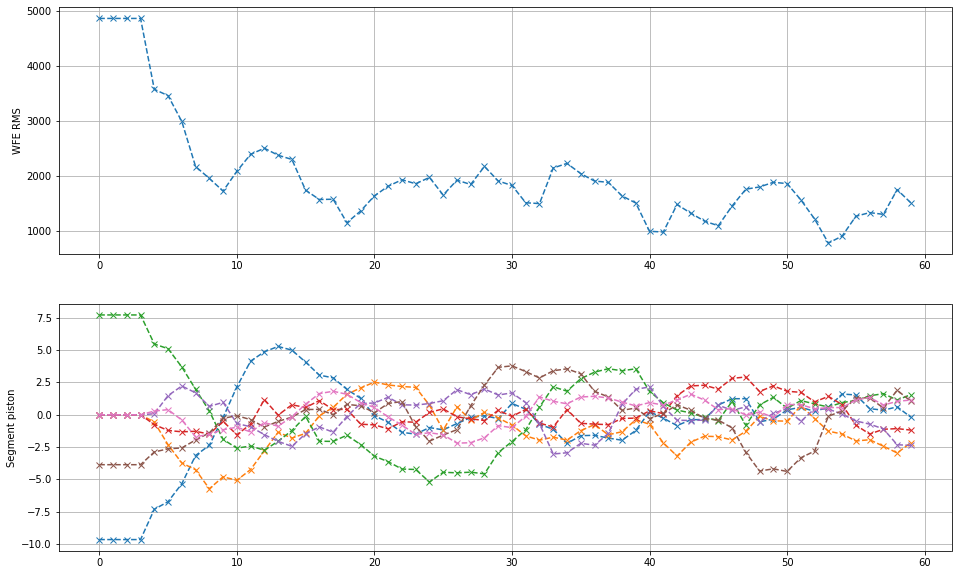

In [20]:
wfe_rms = sim.logs.entries['science']['wfe_rms'].timeSeries
segpiston = sim.logs.entries['science']['segment_piston'].timeSeries

plt.figure(figsize=(16,10))
plt.subplot(211)
plt.plot(wfe_rms[0],wfe_rms[1]*1.0e9,'x--')
#plt.plot(Z[0],zM1_Txyz,'.:')
plt.grid(True)
plt.ylabel('WFE RMS')
    
plt.subplot(212)
plt.plot(segpiston[0],segpiston[1]*1.0e6,'x--')
#plt.plot(Z[0],zM1_Rxyz,'.:')
plt.grid(True)
plt.ylabel('Segment piston') 


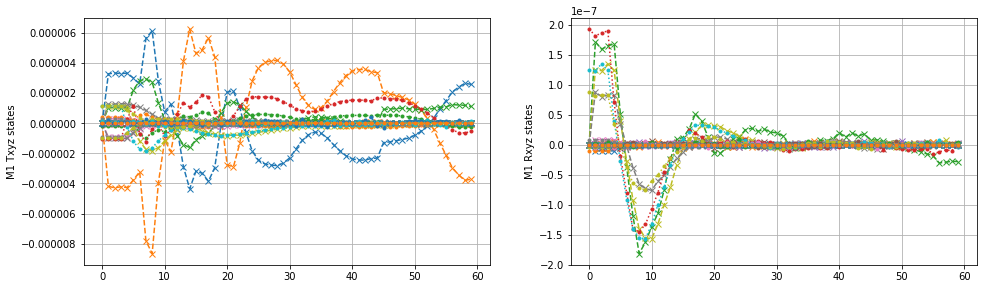

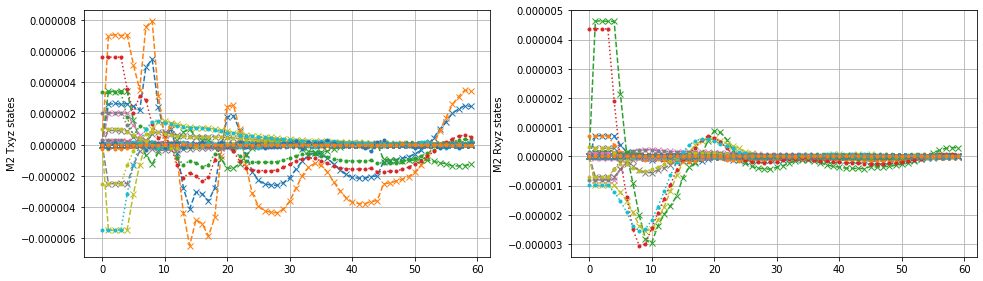

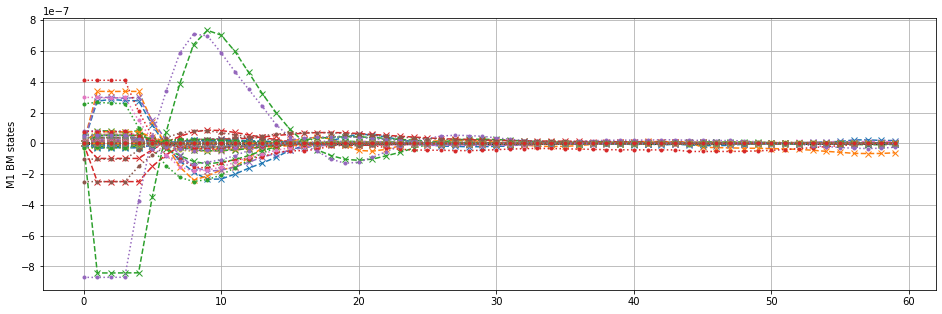

In [16]:
X = sim.logs.entries['ReconstructorM']['x_hat'].timeSeries

# Indices for M1 states
indX = np.reshape(np.arange(X[1].shape[1]), [7, 6 + 6 + 46])
i1,i2,i3,i4,i5 = np.split(indX,[3, 6, 9, 12],axis=1)

xM1_Txyz = X[1][:,np.reshape(i1,[21])]
xM1_Rxyz = X[1][:,np.reshape(i2,[21])]
xM2_Txyz = X[1][:,np.reshape(i3,[21])]
xM2_Rxyz = X[1][:,np.reshape(i4,[21])]
xM1_BM = X[1][:,np.reshape(i5,[46*7])]

Z = sim.logs.entries['wfs48']['M12_RBM'].timeSeries

zM1_Txyz = Z[1][:,np.reshape(i1,[21])]
zM1_Rxyz = Z[1][:,np.reshape(i2,[21])]
zM2_Txyz = Z[1][:,np.reshape(i3,[21])]
zM2_Rxyz = Z[1][:,np.reshape(i4,[21])]
zM1_BM = Z[1][:,np.reshape(i5,[46*7])]

# Plot mirror states
plt.figure(figsize=(16,10))
plt.subplot(221)
plt.plot(X[0],xM1_Txyz,'x--')
plt.plot(Z[0],zM1_Txyz,'.:')
plt.grid(True)
plt.ylabel('M1 Txyz states')
    
plt.subplot(222)
plt.plot(X[0],xM1_Rxyz,'x--')
plt.plot(Z[0],zM1_Rxyz,'.:')
plt.grid(True)
plt.ylabel('M1 Rxyz states')    

plt.figure(figsize=(16,10))
plt.subplot(223)
plt.plot(X[0],xM2_Txyz,'x--')
plt.plot(Z[0],zM2_Txyz,'.:')
plt.grid(True)
plt.ylabel('M2 Txyz states')
    
plt.subplot(224)
plt.plot(X[0],xM2_Rxyz,'x--')
plt.plot(Z[0],zM2_Rxyz,'.:')
plt.grid(True)
plt.ylabel('M2 Rxyz states')   
plt.show()

plt.figure(figsize=(16,5))
plt.plot(X[0],xM1_BM,'x--')
plt.plot(Z[0],zM1_BM,'.:')
plt.grid(True)
plt.ylabel('M1 BM states')
plt.show()

#### Baseline estimator results

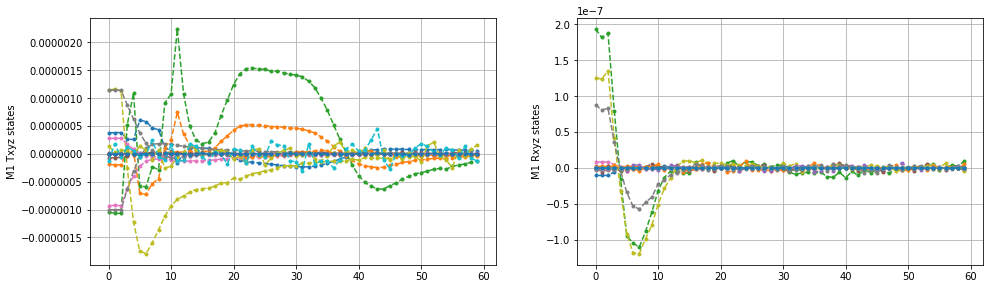

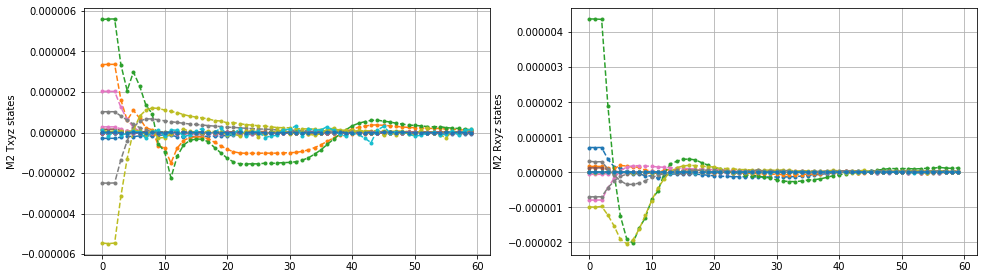

Text(0, 0.5, 'M1 BM states')

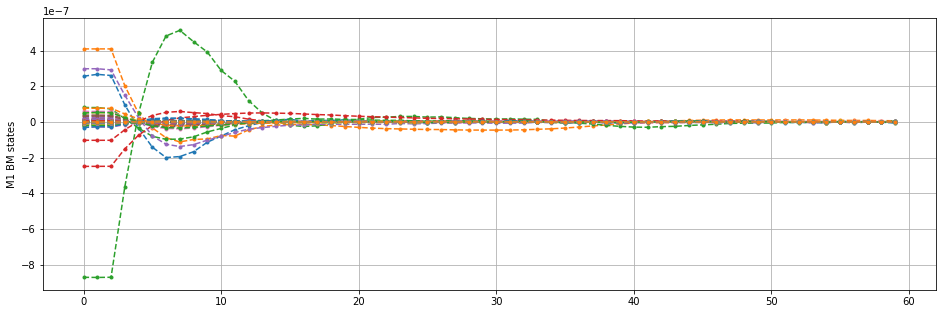

In [11]:
# Plot mirror states

plt.figure(figsize=(16,10))
plt.subplot(221)
plt.plot(Z[0],zM1_Txyz,'.--')
plt.grid(True)
plt.ylabel('M1 Txyz states')
    
plt.subplot(222)
plt.plot(Z[0],zM1_Rxyz,'.--')
plt.grid(True)
plt.ylabel('M1 Rxyz states')    

plt.figure(figsize=(16,10))
plt.subplot(223)
plt.plot(Z[0],zM2_Txyz,'.--')
plt.grid(True)
plt.ylabel('M2 Txyz states')
    
plt.subplot(224)
plt.plot(Z[0],zM2_Rxyz,'.--')
plt.grid(True)
plt.ylabel('M2 Rxyz states')   
plt.show()

plt.figure(figsize=(16,5))
plt.plot(Z[0],zM1_BM,'.--')
plt.grid(True)
plt.ylabel('M1 BM states')

#### Control effort

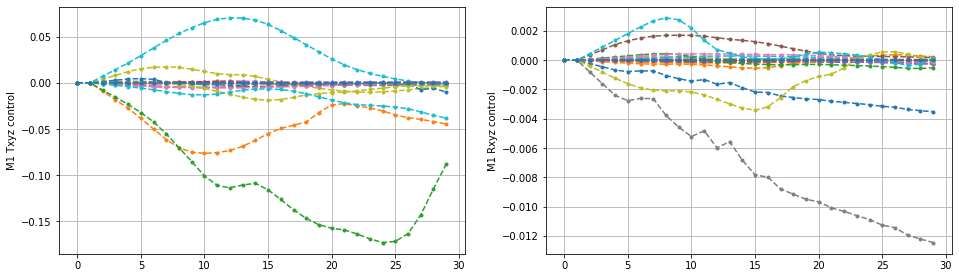

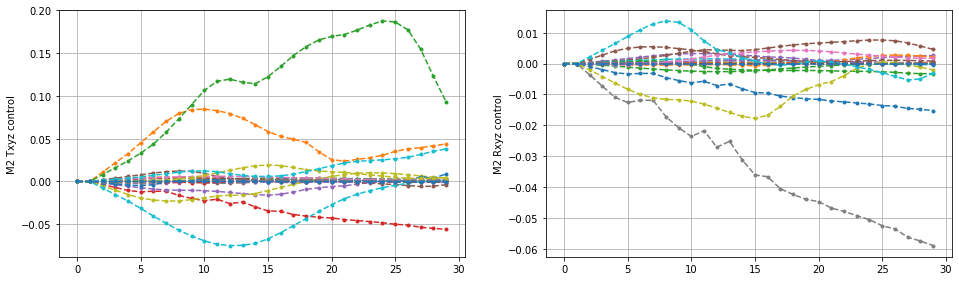

Text(0, 0.5, 'M1 BM control')

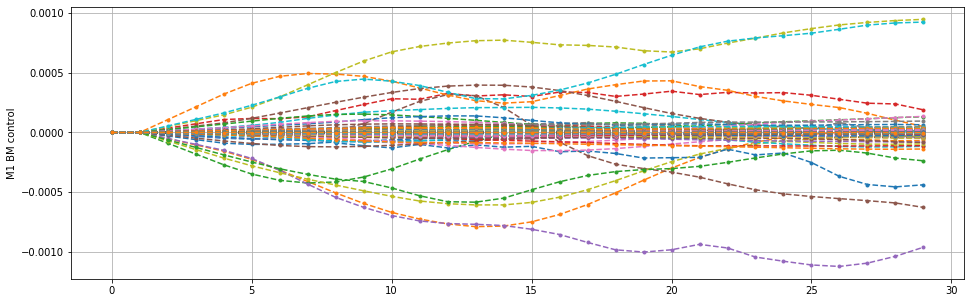

In [9]:
M1Txyz = sim.logs.entries['AcO_controller']['M1 Txyz'].timeSeries
M1Rxyz = sim.logs.entries['AcO_controller']['M1 Rxyz'].timeSeries
M2Txyz = sim.logs.entries['AcO_controller']['M2 Txyz'].timeSeries
M2Rxyz = sim.logs.entries['AcO_controller']['M2 Rxyz'].timeSeries
M1BM = sim.logs.entries['AcO_controller']['M1 BM'].timeSeries

# [Segments, mode:XYZ, Timestamp]
#print(M1Txyz[1][:3,:,3:7])

plt.figure(figsize=(16,10))
plt.subplot(221)
for kmode in range(3):
    for k in M1Txyz[1][:,kmode,:]:
        plt.plot(k,'.--')
plt.grid(True)
plt.ylabel('M1 Txyz control')
    
plt.subplot(222)
for kmode in range(3):
    for k in M1Rxyz[1][:,kmode,:]:
        plt.plot(k,'.--')
plt.grid(True)
plt.ylabel('M1 Rxyz control')    

plt.figure(figsize=(16,10))
plt.subplot(223)
for kmode in range(3):
    for k in M2Txyz[1][:,kmode,:]:
        plt.plot(k,'.--')
plt.grid(True)
plt.ylabel('M2 Txyz control')
    
plt.subplot(224)
for kmode in range(3):
    for k in M2Rxyz[1][:,kmode,:]:
        plt.plot(k,'.--')
plt.grid(True)
plt.ylabel('M2 Rxyz control')   
plt.show()

plt.figure(figsize=(16,5))
for kmode in range(len(M1BM[1][0,:,0])):
    for k in M1BM[1][:,kmode,:]:
        plt.plot(k,'.--')
plt.grid(True)
plt.ylabel('M1 BM control')